In [13]:
from typing import *
import os
from pathlib import Path
from datetime import datetime, date, timedelta
from collections import defaultdict
import pickle
import gc
import warnings

import numpy as np
import pandas as pd
import pandas_profiling as pdp
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from nptyping import NDArray, Shape, Int, Float
from rich import print as rprint
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import lightgbm as lgb
import shap


sns.set(font='Hiragino Sans', style='whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義
DATA_DIR = Path()/'data'
DF_DIR = DATA_DIR/'dataframes'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings('ignore')

def save_pkl(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [2]:
df_train: pd.DataFrame = pd.read_csv(DATA_DIR/'train.csv')
display(df_train.tail(2))
display(df_train.info())

X_train, y_train, id_train = df_train[['Pclass', 'Fare']], df_train[['Survived']], df_train[['PassengerId']]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

In [12]:
cv_idxes = StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_train, y_train)
print(len(X_train), len(y_train))
for nfold, (train_idx, val_idx) in enumerate(cv_idxes):
    print(nfold)
    print(len(train_idx), len(val_idx))


891 891
0
594 297
1
594 297
2
594 297


In [3]:
def holdout(x_train: pd.DataFrame, y_train: pd.DataFrame, test_size: float = 0.2, varbose: bool = False):
    x_tr, x_val, y_tr, y_val = train_test_split(
        x_train, 
        y_train, 
        test_size=test_size, 
        shuffle=True, 
        stratify=y_train, 
        random_state=123)
    if varbose:
        print(f'{x_tr.shape = }, {y_tr.shape = }')
        print(f'{x_val.shape = }, {y_val.shape = }')
        print(f'{y_train["Survived"].mean():.3f}, {y_tr["Survived"].mean():.3f}, {y_val["Survived"].mean():.3f}')

    return x_tr, x_val, y_tr, y_val


def clossval_(x_train: pd.DataFrame, y_train: pd.DataFrame, n_splits: int = 5, varbose: bool = False):
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))
    for nfold in np.arange(n_splits):
        idx_tr, idx_val = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_val, y_val = x_train.loc[idx_val, :], y_train.loc[idx_val, :]
        # ここでモデル学習
    pass


def clossval_predict(
        estimator, 
        df: pd.DataFrame, 
        target_col: str, 
        features: Optional[List[str]] = None, 
        n_splits: int = 5) -> NDArray[Shape['Sample'], Float]:
    if features is None:
        features = df.drop(target_col, axis=1).columns
    X: pd.DataFrame = df[features]
    y: pd.Series = df[target_col]
    y_pred: NDArray[Shape['Sample'], Float] = np.zeros_like(y)
    cv_idxes = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X, y)
    
    

In [28]:
from abc import ABCMeta, abstractmethod

class Trainer(metaclass=ABCMeta):
    def __init__(
            self,
            estimator,
            matrics: List[Callable],
            df: pd.DataFrame, 
            target: str,
            features: Optional[List[str]] = None,
            fitting_params: Dict[str, Any] = {}) -> None:
        self.estimator = estimator
        self.features: List[str] = df.drop(target, axis=1).columns if features is None else features
        self.X: NDArray[Shape['Sample, features'], Float] = df[self.features].values
        self.y: NDArray[Shape['Sample'], Float] = df[target].values
        self.y_pred: NDArray[Shape['Sample'], Float] = np.zeros_like(self.y)
        self.matrics: List[Callable] = matrics
        self.matrics_results: Dict[str, List[float]] = defaultdict(list)
        self.fitting_params: Dict[str, Any] = fitting_params
        self.is_trained: bool = False

    def get_y_pred(self) -> pd.Series:
        if not self.is_trained:
            raise Exception('Untrained!')
        return pd.Series(self.y_pred)

    def get_matrics(self) -> pd.DataFrame:
        if not self.is_trained:
            raise Exception('Untrained!')
        return pd.DataFrame(self.matrics_results)
        
    def train(self, n_splits: int = 5):
        cv_indices = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(self.X, self.y)
        for train_idx, val_idx in tqdm(cv_indices):
            self._train_step(train_idx, val_idx)
        self.is_trained = True

    @abstractmethod
    def _fit(self, X_train, y_train, X_val, y_val) -> None:
        raise NotImplementedError()

    def _train_step(self, train_idx: List[int], val_idx: List[int]) -> None:
        X_train, y_train = self.X[train_idx], self.y[train_idx]
        X_val, y_val = self.X[val_idx], self.y[val_idx]
        self._fit(X_train, y_train, X_val, y_val)
        y_train_pred = self.estimator.predict(X_train)
        y_val_pred = self.estimator.predict(X_val)
        for matric in self.matrics:
            self.matrics_results[f'train_{matric.__name__}'].append(matric(y_train, y_train_pred))
            self.matrics_results[f'val_{matric.__name__}'].append(matric(y_val, y_val_pred))
        self.y_pred[val_idx] = y_val_pred
            

class GBDTTrainer(Trainer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.importances = []
    
    def _fit(self, X_train, y_train, X_val, y_val) -> None:
        self.estimator.fit(
            X=X_train, 
            y=y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            **self.fitting_params)
        self.importances.append(self.estimator.feature_importances_)

    def get_feature_importances(self) -> pd.DataFrame:
        if not self.is_trained:
            raise Exception('Untrained!')
        return pd.DataFrame(self.importances, columns=self.features)
        

In [22]:
# light gbmによる学習

x_tr, x_val, y_tr, y_val = holdout(X_train, y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain'}

model = lgb.LGBMClassifier(**params)
model.fit(
    X=x_tr,
    y=y_tr,
    eval_set=[(x_tr, y_tr), (x_val, y_val)],
    early_stopping_rounds=100,
    verbose=10)

print('############')

explainer = shap.TreeExplainer(model, data=x_tr)
print(type(explainer))
print(isinstance(explainer, shap.Explainer))
shap_values = explainer.shap_values(x_tr)
print(shap_values.shape)
print(shap_values)

print(model.feature_importances_)
print(model.feature_importances_.shape)



[10]	training's auc: 0.792256	valid_1's auc: 0.744862
[20]	training's auc: 0.801914	valid_1's auc: 0.752372
[30]	training's auc: 0.808339	valid_1's auc: 0.759223
[40]	training's auc: 0.816595	valid_1's auc: 0.759223
[50]	training's auc: 0.820771	valid_1's auc: 0.755138
[60]	training's auc: 0.82582	valid_1's auc: 0.754809
[70]	training's auc: 0.82995	valid_1's auc: 0.753755
[80]	training's auc: 0.832645	valid_1's auc: 0.752767
[90]	training's auc: 0.834593	valid_1's auc: 0.750132
[100]	training's auc: 0.837247	valid_1's auc: 0.747892
[110]	training's auc: 0.839036	valid_1's auc: 0.746838
[120]	training's auc: 0.840764	valid_1's auc: 0.746311
[130]	training's auc: 0.842007	valid_1's auc: 0.746706
############
<class 'shap.explainers._tree.Tree'>
True
(712, 2)
[[-0.29918924 -0.63839463]
 [-0.60846724 -0.41161303]
 [ 0.7133053  -0.08852714]
 ...
 [ 0.51369346  1.50209476]
 [-0.68543833 -0.38944187]
 [ 0.46292456  1.07818228]]
[229.45718631 903.44037275]
(2,)


In [29]:
from sklearn.metrics import accuracy_score

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain'}

model = lgb.LGBMClassifier(**params)

df_train: pd.DataFrame = pd.read_csv(DATA_DIR/'train.csv')

trainer: GBDTTrainer = GBDTTrainer(
    estimator=model, 
    matrics=[accuracy_score], 
    df=df_train, 
    target='Survived', 
    features=['Pclass', 'Fare'],
    fitting_params={'early_stopping_rounds': 100})

trainer.train()


0it [00:00, ?it/s]

[1]	training's auc: 0.755751	valid_1's auc: 0.771476
[2]	training's auc: 0.757562	valid_1's auc: 0.765942
[3]	training's auc: 0.758913	valid_1's auc: 0.771212
[4]	training's auc: 0.760019	valid_1's auc: 0.768182
[5]	training's auc: 0.764742	valid_1's auc: 0.774111
[6]	training's auc: 0.764742	valid_1's auc: 0.772793
[7]	training's auc: 0.765476	valid_1's auc: 0.772464
[8]	training's auc: 0.766836	valid_1's auc: 0.772398
[9]	training's auc: 0.770678	valid_1's auc: 0.777404
[10]	training's auc: 0.776573	valid_1's auc: 0.78386
[11]	training's auc: 0.780587	valid_1's auc: 0.78531
[12]	training's auc: 0.782051	valid_1's auc: 0.783531
[13]	training's auc: 0.782635	valid_1's auc: 0.784783
[14]	training's auc: 0.783224	valid_1's auc: 0.786232
[15]	training's auc: 0.785372	valid_1's auc: 0.78722
[16]	training's auc: 0.785794	valid_1's auc: 0.784256
[17]	training's auc: 0.788831	valid_1's auc: 0.777273
[18]	training's auc: 0.790258	valid_1's auc: 0.778327
[19]	training's auc: 0.790767	valid_1's 

In [43]:
df_importance = trainer.get_feature_importances()

d = df_importance.mean().sort_values(ascending=False)

,gain
Fare,948.028593
Pclass,361.413778


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


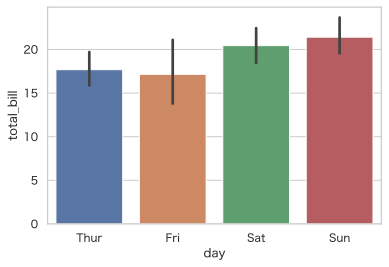

In [35]:
import seaborn as sns
tips = sns.load_dataset("tips")
display(tips)
ax = sns.barplot(x="day", y="total_bill", data=tips)